In [1]:
from IFD_tsne import *
from utils import load_data, MidpointNormalize, equipotential_standard_normal, plot_heatmaps
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from tueplots import figsizes, fonts, bundles
from tueplots import cycler
from tueplots.constants import markers
from tueplots.constants.color import palettes
import tsne_jax

# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 150})
from jax.config import config
config.update("jax_enable_x64", True)

# Laplace Approximation tsne 

In [2]:
X, y = make_blobs(n_samples=50, n_features=50, centers=4, random_state=0, shuffle=False, cluster_std=3)
#X, y = load_data(50)
key = random.PRNGKey(42)
#X = onp.array(random.normal(key, shape=(50, 50)))
y_guess = random.normal(key, shape=(X.shape[0], 2))
Y_star = tsne_fwd(X, y_guess)

===> Finding 49 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.05 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds


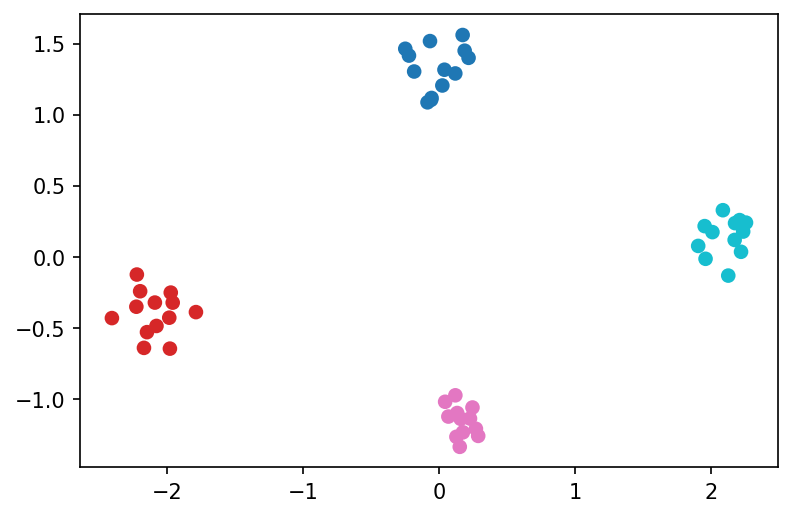

In [3]:
plt.scatter(Y_star[:, 0], Y_star[:, 1], c=y, cmap='tab10')

In [26]:
dy, H, J = d_y_star_d_x_outer(KL_divergence_log, X, Y_star)

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


In [27]:
print('Rank of Hessian ', np.linalg.matrix_rank(H)) 

Rank of Hessian  100


In [28]:
print('Determinant of Hessian', np.linalg.det(H))

Determinant of Hessian 9.154094016903026e-292


In [23]:
H = H+1e-6*np.eye(len(H))

In [31]:
S = equipotential_standard_normal(2 * X.shape[0], 20)
# A=L*L'
# L*L'*A_inv = eye(n,n)
# Substitute u = L'*A_inv
# Solve problem L*u = eye(n,n)
# u is known now, so solve second problem L'*A_inv = u
L, lower = jax.scipy.linalg.cho_factor(H, lower=True)
u = jax.scipy.linalg.solve_triangular(L, np.eye(np.shape(L)[0]), lower=True)
L_t, lower = jax.scipy.linalg.cho_factor(H, lower=False)
H_inv = jax.scipy.linalg.solve_triangular(L_t, u, lower=False)

/mnt/qb/work/coe/szabel09/src/tsne/utils.py:82: RuntimeWarning: invalid value encountered in true_divide
  M = np.dot(mu, np.expand_dims(np.cos(theta), axis=0)) + E * np.sin(theta) / theta


[100040.83743062 100000.         100000.           2924.70769579
   2607.75929941   2444.02907062   1911.17505547   1849.93768701
   1779.51250164   1656.84038057   1627.5158653    1608.24886843
   1455.28460402   1383.18553299   1339.78912309   1279.66401524
   1239.54029606   1217.48317919   1199.5331342    1128.98716048
   1126.57316399   1115.51756528   1076.5759722    1067.85732098
   1050.29580093   1043.99793767    996.87249595    952.9763007
    947.80842858    906.40843248    904.09335869    893.35366545
    871.35113355    855.45102742    850.36944014    836.99467499
    815.88345064    789.25845693    780.89083476    773.90141902
    759.82978285    745.71410594    730.0283216     727.92316779
    719.12303859    710.05737408    706.06157864    691.44699634
    690.0705816     688.87311817    673.75469589    664.9636659
    664.54453913    648.91974455    646.42700406    636.2260915
    627.70212215    621.67050476    598.84959077    585.54269606
    582.15375122    577.1398

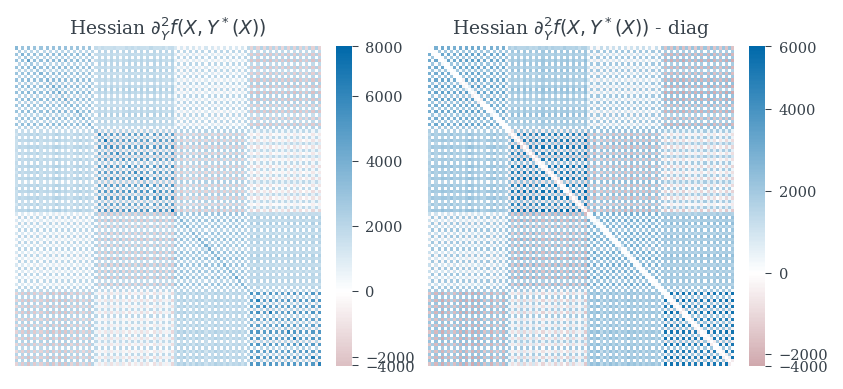

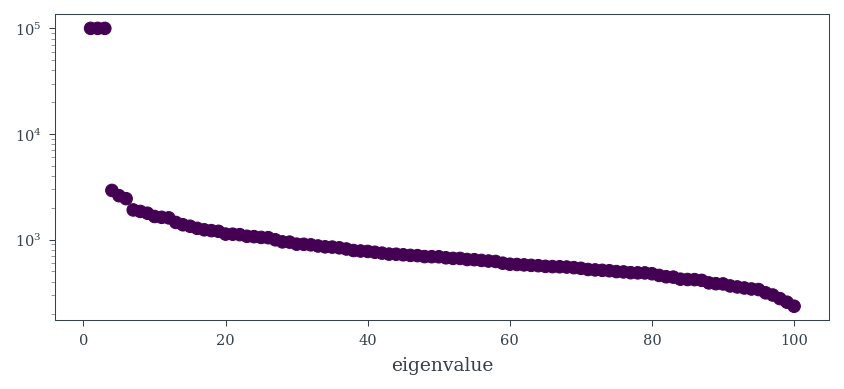

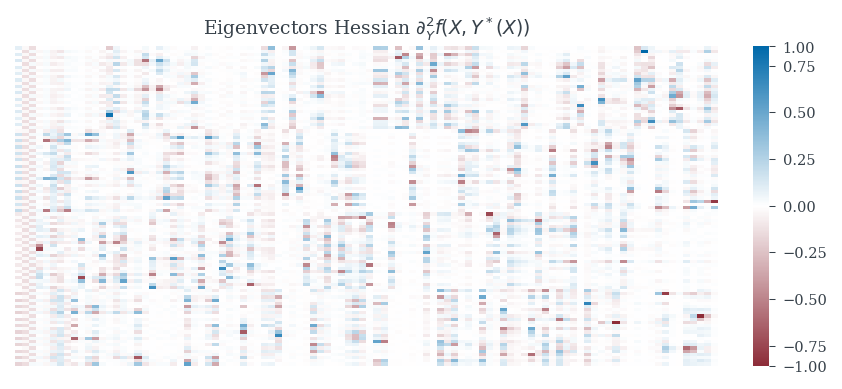

In [30]:
plot_heatmaps(None, H_inv, None)

In [32]:
L, lower = jax.scipy.linalg.cho_factor(H_inv, lower=True)

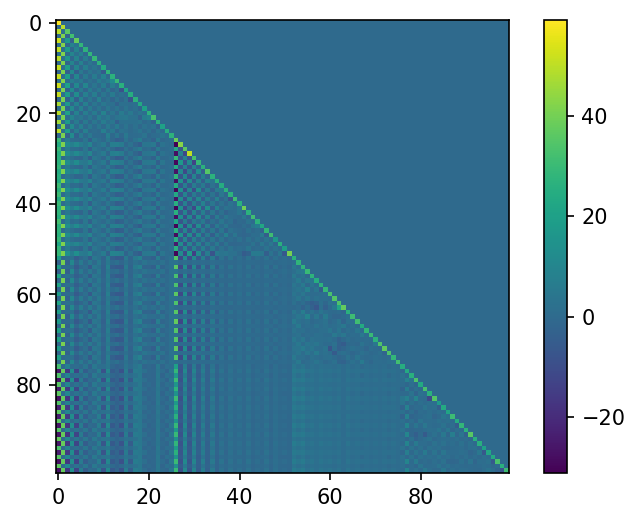

In [33]:
plt.imshow(L)
plt.colorbar()

In [34]:
Y_star_flat, Y_unflattener = flatten_util.ravel_pytree(Y_star)
samples = np.transpose(np.transpose(np.dot(L, S))+Y_star_flat)
np.save('laplace_approximation/samples.npy', samples)
np.save('laplace_approximation/labels.npy', y)
np.save('laplace_approximation/mean.npy', Y_star)

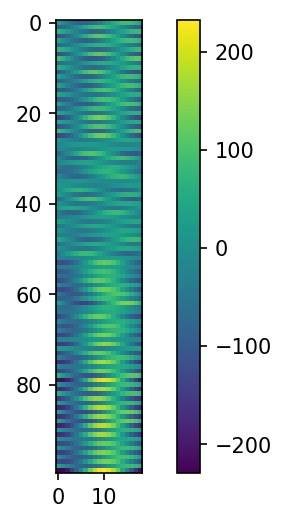

In [35]:
plt.imshow(np.dot(L, S))
plt.colorbar()

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
for i, ax in zip(np.transpose(samples), axs.ravel()):
    Y_sample = Y_unflattener(i)
    ax.scatter(Y_sample[:, 0], Y_sample[:, 1])

In [ ]:
with plt.rc_context(bundles.beamer_moml()):
    fig, ax1 = plt.subplots()
    sns.heatmap(H_inv, cmap='bwr', norm=(MidpointNormalize(midpoint=0, vmin=onp.min(H_inv), vmax=onp.max(H_inv))), ax=ax1)
    ax1.set_title('Hessian $\partial_Y^2 f(X, Y^*(X))$')
    ax1.tick_params(bottom=False, left=False)
    ax1.set(xticklabels=[], yticklabels=[])